In [34]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")


In [35]:
data = pd.read_csv("HistoricalQuotes.csv")



In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         2518 non-null   object
 1    Close/Last  2518 non-null   object
 2    Volume      2518 non-null   int64 
 3    Open        2518 non-null   object
 4    High        2518 non-null   object
 5    Low         2518 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.2+ KB


In [37]:
data.columns = data.columns.str.strip()

In [38]:
dollar_col=["Close/Last","Open","High","Low"]
for col in dollar_col:
    data[col]=data[col].replace('[\$,]', '',regex=True).astype(float)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        2518 non-null   object 
 1   Close/Last  2518 non-null   float64
 2   Volume      2518 non-null   int64  
 3   Open        2518 non-null   float64
 4   High        2518 non-null   float64
 5   Low         2518 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 118.2+ KB


In [40]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [41]:
data.sort_values('Date',inplace=True)

In [42]:
close=data["Close/Last"]

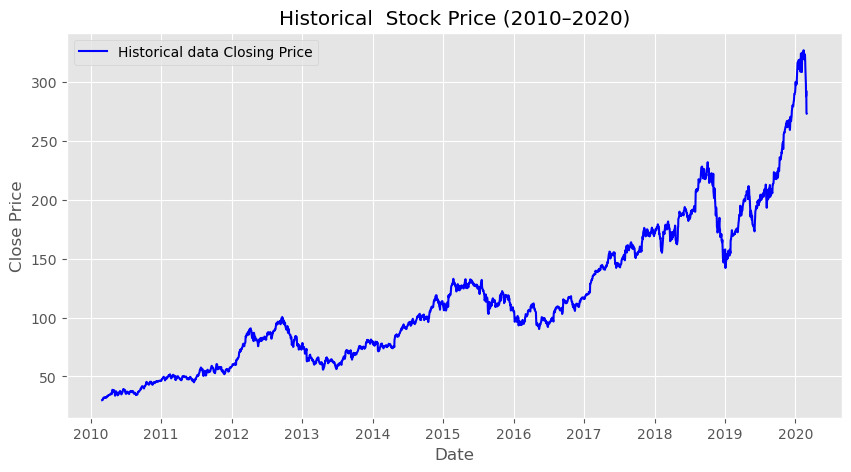

In [44]:
plt.figure(figsize=(10,5))
plt.plot(close, label='Historical data Closing Price',color="blue")
plt.title('Historical  Stock Price (2010–2020)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [11]:
close = close.sort_index()

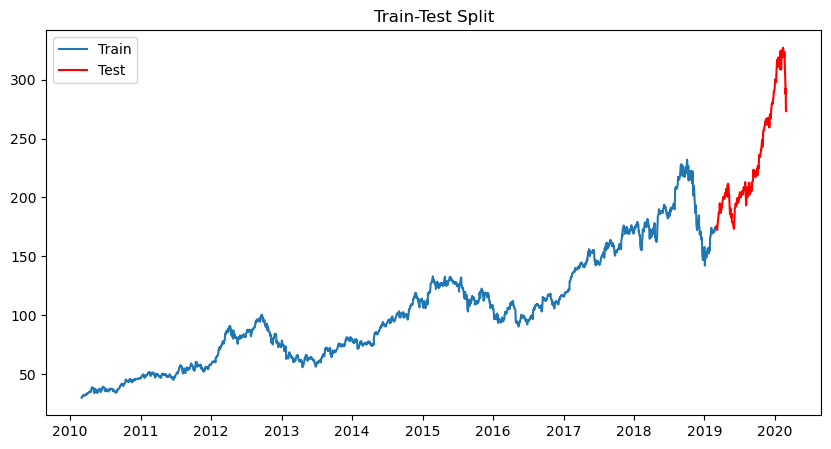

In [12]:
train_size = int(len(close) * 0.9)
train, test = close[:train_size], close[train_size:]

plt.figure(figsize=(10,5))
plt.plot(train, label='Train')
plt.plot(test, label='Test',color="red")
plt.title('Train-Test Split')
plt.legend()
plt.show()


Checking for stationarity

In [13]:
result = adfuller(train)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] <= 0.05 :
    print("the data is stationary")
else:
    print("differencing is needed")




ADF Statistic: -1.0290853748765805
p-value: 0.742508840898626
differencing is needed


In [14]:
train_diff = train.diff().dropna()


# Check stationarity again
result = adfuller(train_diff)
print('ADF after differencing:', result[0])
print('p-value:', result[1])

if result[1] <= 0.5:
    print("the data is stationary")
else:
    print("differencing is needed again")

ADF after differencing: -7.521840340086722
p-value: 3.7728374924495575e-11
the data is stationary


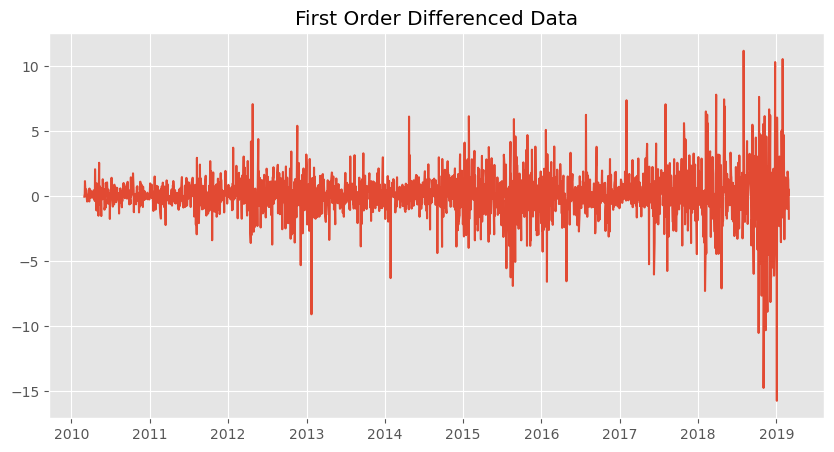

In [15]:
plt.style.use("ggplot")
plt.figure(figsize=(10,5))
plt.plot(train_diff)
plt.title('First Order Differenced Data')
plt.show()


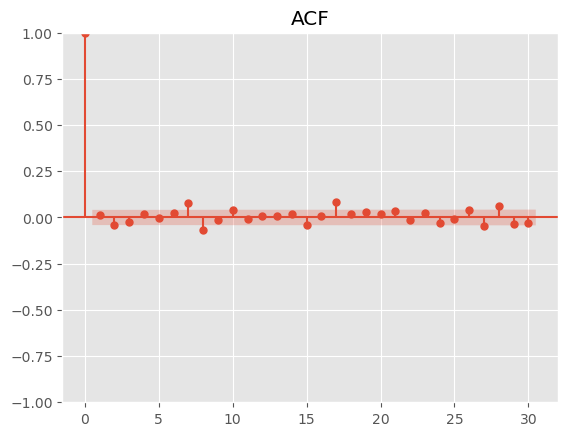

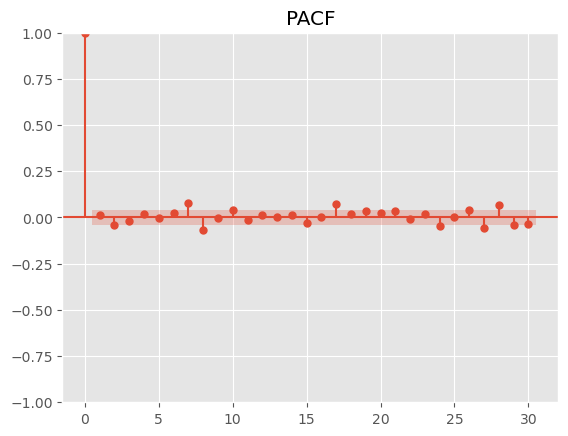

In [16]:
plot_acf(train_diff, lags=30)
#plt.figure(figsize=(8,4))
plt.title('ACF')
plt.show()

plot_pacf(train_diff, lags=30)
#plt.figure(figsize=(8,4))
plt.title('PACF')
plt.show()


In [17]:
# stepwise_model = auto_arima(train, seasonal=False, trace=True)
# print(stepwise_model.summary())




In [18]:
from pmdarima import auto_arima

stepwise_model = auto_arima(train,
                            start_p=1, start_q=1,
                            max_p=5, max_q=5,
                            seasonal=True,
                            m=12,  # Adjust seasonality depending on your data
                            start_P=0, start_Q=0,
                            max_P=2, max_Q=2,
                            d=None, D=1,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(stepwise_model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=10483.851, Time=1.30 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=14623.321, Time=0.31 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=9935.141, Time=4.08 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=12605.221, Time=5.99 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=14654.118, Time=0.24 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=10490.274, Time=0.81 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=9681.687, Time=13.54 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=22.90 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=8.03 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=14595.533, Time=4.71 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=9676.463, Time=12.29 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=9934.505, Time=5.04 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=36.08 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=19.28 sec
 ARIMA(3,0,0)(2,1,0)[12] int

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the model using the best pdq + seasonal pdq from auto_arima
model = SARIMAX(train,
                order=(3, 1, 0),
                seasonal_order=(2, 1, 0, 12),  # yearly seasonality
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
model_fit = model.fit(disp=False)

# Summary
print(model_fit.summary())



                                     SARIMAX Results                                      
Dep. Variable:                         Close/Last   No. Observations:                 2266
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -4796.163
Date:                            Wed, 21 May 2025   AIC                           9604.326
Time:                                    13:47:08   BIC                           9638.574
Sample:                                         0   HQIC                          9616.834
                                           - 2266                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0413      0.014      3.037      0.002       0.015       0.068
ar.L2         -0.0546      0.015   

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train,
                order=stepwise_model.order,
                seasonal_order=stepwise_model.seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit(disp=False)

forecast_result = model_fit.get_forecast(steps=len(test))
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()


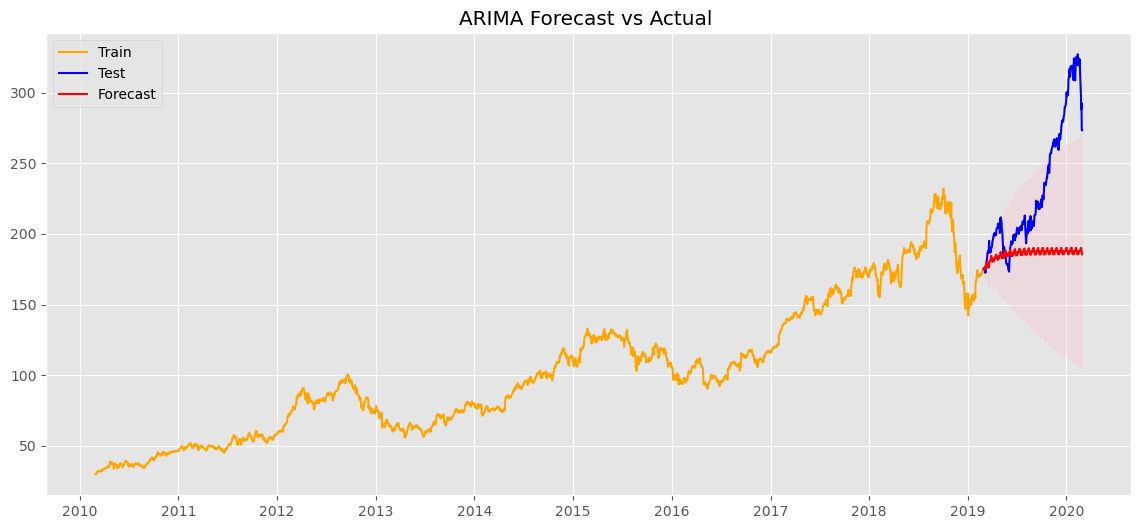

In [45]:
forecast_result = model_fit.get_forecast(steps=len(test))
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()
plt.figure(figsize=(14, 6))
plt.plot(train.index, train, label="Train", color="orange")
plt.plot(test.index, test, label="Test", color="blue")
plt.plot(test.index, forecast_mean, label="Forecast", color="red")
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("ARIMA Forecast vs Actual ")
plt.legend()
plt.show()


In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

forecast_mean = forecast_result.predicted_mean  # Make sure this is defined

# Ensure test and forecast are aligned in length and index
forecast_mean = forecast_mean[:len(test)]  # In case of any length mismatch

mse = mean_squared_error(test, forecast_mean)
mae = mean_absolute_error(test, forecast_mean)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")


MSE: 3975.08
MAE: 46.44


In [23]:
p, d, q = 3, 1, 2
P, D, Q, s = 3, 1, 2, 5  # For weekly seasonality on daily data

from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,s))
model_fit = model.fit()


In [24]:
seasonal_diff = train.diff(s).dropna()


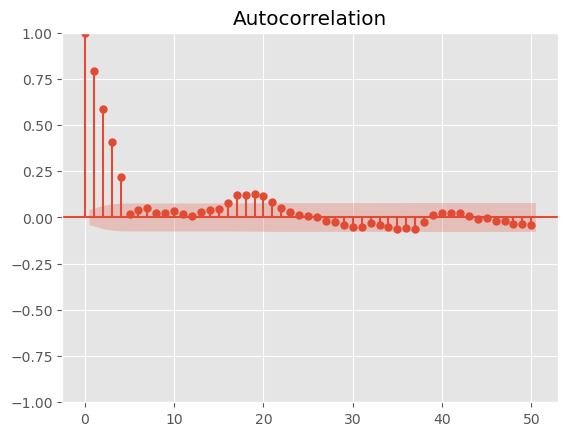

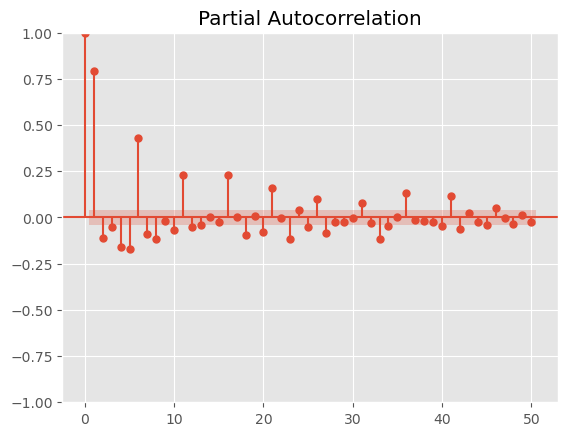

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(seasonal_diff, lags=50)
plot_pacf(seasonal_diff, lags=50)
plt.show()


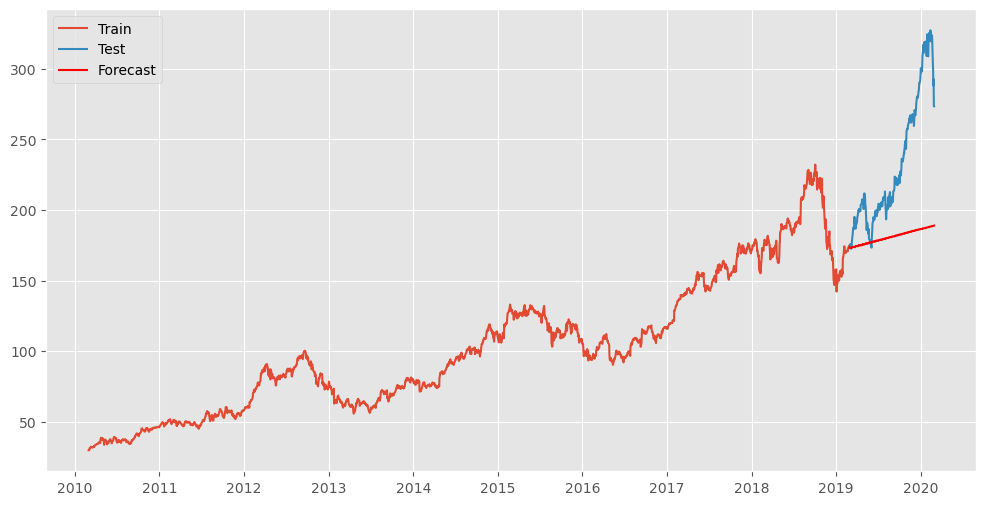

In [26]:
forecast_result1 = model_fit.forecast(steps=len(test))
plt.figure(figsize=(12,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast_result1, label='Forecast', color='red')
plt.legend()
plt.show()


In [27]:
forecast_mean = forecast_result1  # Already a Series


In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

forecast_mean = forecast_mean[:len(test)]  # Just in case lengths mismatch

mse = mean_squared_error(test, forecast_mean)
mae = mean_absolute_error(test, forecast_mean)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")


MSE: 4240.77
MAE: 50.99


In [33]:
from pmdarima import auto_arima

model = auto_arima(train, 
                   start_p=0, max_p=5,
                   start_q=0, max_q=5,
                   d=None,  # let it decide differencing
                   seasonal=False,  # or True if data is seasonal
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9073.467, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9074.959, Time=1.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9074.912, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9074.289, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9075.975, Time=1.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 3.560 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2266
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4534.734
Date:                Wed, 21 May 2025   AIC                           9073.467
Time:                        13:49:33   BIC                           9084.918
Sample:                             0   HQIC                          9077.645
                               - 2266                                       